In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [15]:
# Resim boyutu ve batch size
IMG_SIZE = 224
BATCH_SIZE = 16 # Batch boyutunu daha da küçülttük
PATCH_SIZE = 16
NUM_CLASSES = 5  # Sınıf sayısı

# Eğitim veri kümesini yükleme
train_dir = "/content/drive/My Drive/DDATA_SET/train"
test_dir = "/content/drive/My Drive/DDATA_SET/test"

# TensorFlow için çok çekirdekli işlem ayarları (TensorFlow 2.x ile uyumlu)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU bulunamadı, CPU üzerinde işlem yapılıyor.")

# Eğitim veri kümesini daha verimli şekilde yükleme
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

GPU bulunamadı, CPU üzerinde işlem yapılıyor.
Found 2112 files belonging to 5 classes.
Found 528 files belonging to 5 classes.


In [17]:
# Basit veri augmentasyonu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2)  # Kontrast arttırma
])

# Veri kümesini normalleştirme (0-1 aralığına getirir)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Veri kümesini performans için optimize etme
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# Patch çıkarma katmanı (Swin Transformer için)
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Patch Embedding katmanı
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        embedded_patches = self.projection(patches) + self.position_embedding(positions)
        return embedded_patches


In [19]:
# Swin Transformer blokları
def swin_transformer_block(inputs, num_heads, mlp_dim, dropout_rate):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    x = layers.Dropout(dropout_rate)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(mlp_dim, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# Swin Transformer modelini oluşturma
def create_swin_model(input_shape, patch_size, num_patches, projection_dim, transformer_layers, num_heads, mlp_dim, dropout_rate, num_classes):
    inputs = layers.Input(shape=input_shape)
    patches = PatchExtractor(patch_size)(inputs)
    embedded_patches = PatchEmbedding(num_patches, projection_dim)(patches)

    x = embedded_patches
    for _ in range(transformer_layers):
        x = swin_transformer_block(x, num_heads, mlp_dim, dropout_rate)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(mlp_dim, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Model parametreleri
input_shape = (IMG_SIZE, IMG_SIZE, 3)
patch_size = PATCH_SIZE
num_patches = (IMG_SIZE // patch_size) ** 2
projection_dim = 128  # Projection dim boyutunu küçülttük
transformer_layers = 1  # Transformer katmanlarını küçülttük
num_heads = 4
mlp_dim = 256  # MLP boyutunu küçülttük
dropout_rate = 0.1
# Modeli oluşturma
swin_model = create_swin_model(
    input_shape=input_shape,
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    dropout_rate=dropout_rate,
    num_classes=NUM_CLASSES
)


In [20]:
# Modeli derleme
swin_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model özeti
swin_model.summary()

# Erken durdurma
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modeli eğitme
history = swin_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_extractor_1         │ (None, None, 768)      │              0 │ input_layer_4[0][0]    │
│ (PatchExtractor)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding_1         │ (None, 196, 128)       │        123,520 │ patch_extractor_1[0][… │
│ (PatchEmbedding)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 196, 128)       │            256 │ patch_embedding_1[0][… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 196, 128)       │        263,808 │ layer_normalization_3… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 196, 128)       │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 196, 128)       │              0 │ dropout_5[0][0],       │
│                           │                        │                │ patch_embedding_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 196, 128)       │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 196, 256)       │         33,024 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 196, 256)       │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 196, 128)       │         32,896 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 196, 128)       │              0 │ dense_7[0][0],         │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 196, 128)       │            256 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 25088)          │              0 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │      6,422,784 │ flatten_1[0][0]        │
├──────────────────────

 Total params: 6,878,085 (26.24 MB)

 Trainable params: 6,878,085 (26.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 137s 488ms/step - accuracy: 0.1867 - loss: 2.4661 - val_accuracy: 0.2008 - val_loss: 1.6204
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.2094 - loss: 1.6093 - val_accuracy: 0.2008 - val_loss: 1.6701
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 471ms/step - accuracy: 0.2027 - loss: 1.6172 - val_accuracy: 0.2008 - val_loss: 1.6094
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 473ms/step - accuracy: 0.1952 - loss: 1.6094 - val_accuracy: 0.2008 - val_loss: 1.6094
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 468ms/step - accuracy: 0.2033 - loss: 1.6095 - val_accuracy: 0.2008 - val_loss: 1.6094
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 471ms/step - accuracy: 0.1850 - loss: 1.6096 - val_accuracy: 0.2008 - val_loss: 1.6094
Epoch 7/20


KeyboardInterrupt: 

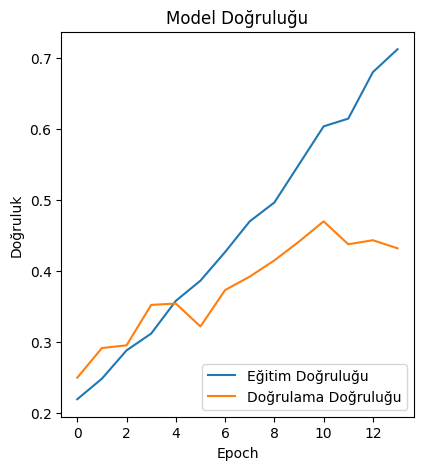

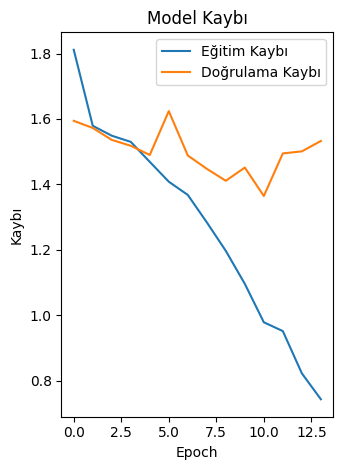

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Eğitimin doğruluğu ve kaybı
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend(loc='lower right')
plt.show()

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kaybı')
plt.legend(loc='upper right')

plt.tight_layout()

plt.show()


In [9]:
import time
# Test Doğruluğu ve Kaybı
test_loss, test_acc = swin_model.evaluate(test_dataset)
print(f"Test doğruluğu: {test_acc:.4f}, Test kaybı: {test_loss:.4f}")

# Sınıflandırma sonuçları
images, labels = next(iter(test_dataset))  # Test veri kümesinden bir batch alın
predictions = swin_model.predict(images)  # Tahminler yapılır
predicted_classes = tf.argmax(predictions, axis=-1)  # En yüksek olasılığa sahip sınıfı seç

print("Gerçek Etiketler:", labels[:10])
print("Tahmin Edilen Etiketler:", predicted_classes[:10])

# Test veri kümesi üzerinde çıkarım süresi
start_time = time.time()
y_pred_probs = swin_model.predict(test_dataset)
inference_time = time.time() - start_time
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.4648 - loss: 1.3519
Test doğruluğu: 0.4697, Test kaybı: 1.3646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Gerçek Etiketler: tf.Tensor([3 2 2 0 2 1 1 1 1 1], shape=(10,), dtype=int32)
Tahmin Edilen Etiketler: tf.Tensor([3 1 1 2 2 4 1 1 1 0], shape=(10,), dtype=int64)
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step
Çıkarım Süresi: 5.62 saniye


Karmaşıklık Matrisi:
 [[44  7 19  3 33]
 [10 35 30 17 14]
 [ 8 24 46 15 13]
 [ 4 13 19 61  9]
 [17  8  6 11 62]]
Sensitivity (Recall): {0: 0.41509433962264153, 1: 0.330188679245283, 2: 0.4339622641509434, 3: 0.5754716981132075, 4: 0.5961538461538461}
Specificity: {0: 0.9075829383886256, 1: 0.8767772511848341, 2: 0.8246445497630331, 3: 0.8909952606635071, 4: 0.8372641509433962}
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.53      0.42      0.47       106
           1       0.40      0.33      0.36       106
           2       0.38      0.43      0.41       106
           3       0.57      0.58      0.57       106
           4       0.47      0.60      0.53       104

    accuracy                           0.47       528
   macro avg       0.47      0.47      0.47       528
weighted avg       0.47      0.47      0.47       528



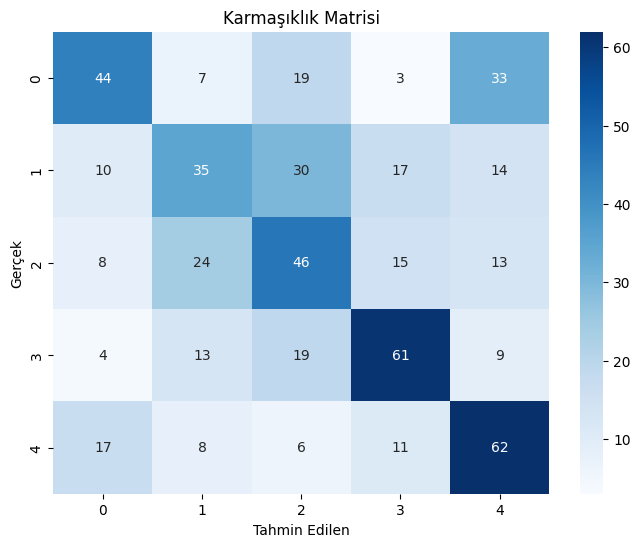

In [10]:


import numpy as np

# Metrik hesaplama
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Karmaşıklık Matrisi
conf_matrix = confusion_matrix(y_true, y_pred)
print("Karmaşıklık Matrisi:\n", conf_matrix)
num_classes=5

# Sensitivity (Recall) ve Specificity Hesaplama
sensitivity = {}
specificity = {}
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fn = conf_matrix[i, :].sum() - tp
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (tp + fn + fp)
    sensitivity[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")

# Classification Raporu
class_report = classification_report(y_true, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karmaşıklık Matrisi görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

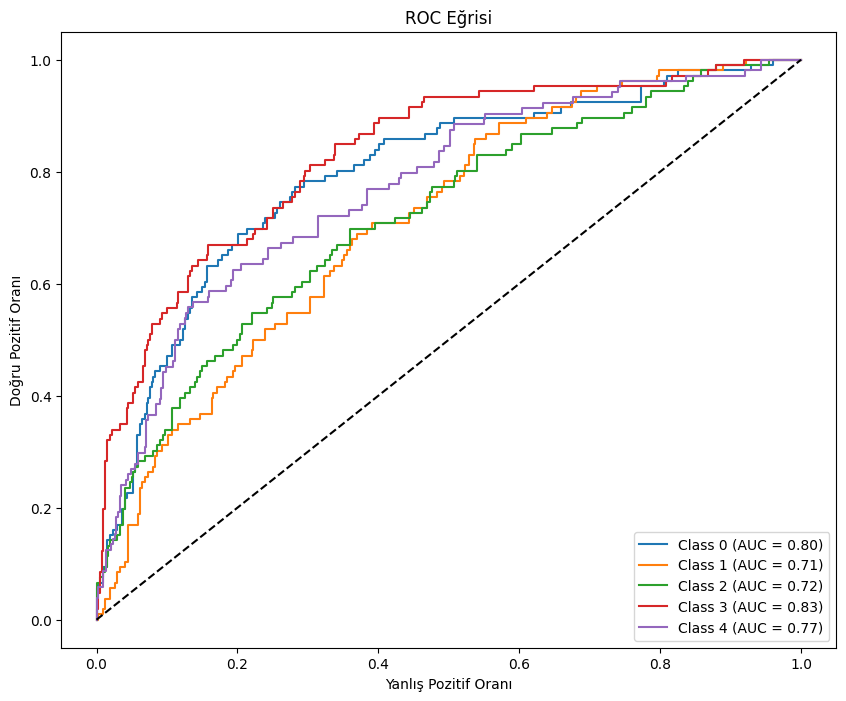

In [11]:

from sklearn.metrics import roc_curve, auc

true_labels = np.array(y_true)  # Listeyi numpy dizisine dönüştür
pred_probs = np.vstack([swin_model.predict(images) for images, _ in test_dataset])

# ROC Eğrileri ve AUC Hesaplama
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print("ROC AUC Değerleri:\n", roc_auc)

# ROC eğrilerini çiz
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eğrisi")
plt.xlabel("Yanlış Pozitif Oranı")
plt.ylabel("Doğru Pozitif Oranı")
plt.legend(loc="lower right")
plt.show()


In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np


image_paths = [
    '/content/image_1.png',
    '/content/image_2.png',
    '/content/image_3.png',
    '/content/image_4.png',
    '/content/image_5.png'
]


for i, image_path in enumerate(image_paths, 1):

    img = image.load_img(image_path, target_size=(224, 224))  # İndirilen dosya yolunu kullan

    # Fotoğrafı numpy dizisine dönüştürme
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Fotoğrafı normalize etme
    img_array = img_array / 255.0

    # Tahmin yapma
    predictions = swin_model.predict(img_array)

    # Tahmin edilen sınıf
    predicted_class = np.argmax(predictions, axis=-1)

    # class_names = list(test_dataset.class_indices.keys())

    class_names = ["kifoz", "pektus_ekskavatum", "pektus_karinatum", "poland_sendromu", "skolyoz"]  # Sınıf isimlerini buraya yazın


    print(f"{i}. Resim: Tahmin Edilen Sınıf: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1. Resim: Tahmin Edilen Sınıf: skolyoz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2. Resim: Tahmin Edilen Sınıf: skolyoz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3. Resim: Tahmin Edilen Sınıf: poland_sendromu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4. Resim: Tahmin Edilen Sınıf: pektus_ekskavatum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5. Resim: Tahmin Edilen Sınıf: skolyoz
